In [1]:
from transformers import RobertaTokenizer
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import xgboost as xgb
from transformers import T5Tokenizer, T5Model
import torch
from transformers import T5Tokenizer, T5EncoderModel
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers, processors
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MaxAbsScaler
import fasttext.util
from transformers import T5Tokenizer, T5EncoderModel
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch

In [2]:
def preprocess_data_t5(file_path, t5_model_name='t5-base'):
    # Load the data
    df = pd.read_excel(file_path)
    
    # Ensure that 'Text' column is used as the independent variable
    df['Text'] = df['Text'].astype(str)
    
    # Drop any rows where 'Text' or 'Type' is NaN
    df.dropna(subset=['Text', 'Type'], inplace=True)
    
    # Define features and labels
    X = df['Text']
    y = df['Type']
    
    # Encode the labels into numeric values
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Load pre-trained T5 model and tokenizer
    tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
    model = T5EncoderModel.from_pretrained(t5_model_name)
    
    # Tokenize the text data using T5 and obtain embeddings
    def get_t5_embeddings(text):
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embeddings = model(**inputs).last_hidden_state.mean(dim=1)
        return embeddings.squeeze().numpy()
    
    # Apply the T5 embeddings function to the text data
    X_tokenized = X.apply(lambda text: get_t5_embeddings(text))
    
    # Convert the list of embeddings to a 2D array
    X_tokenized = pd.DataFrame(X_tokenized.tolist())
    
    # Split the data into training and test sets (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(X_tokenized, y_encoded, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test, label_encoder, model, tokenizer

# Example of using the function
file_path = 'test.xlsx'
X_train, X_test, y_train, y_test, label_encoder, t5_model, t5_tokenizer = preprocess_data_t5(file_path)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [3]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, label_encoder, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Results for SVM:
Training Accuracy: 0.8708
Test Accuracy: 0.7380
Classification Report:
              precision    recall  f1-score   support

      Answer       0.66      0.58      0.62       323
    Question       0.91      0.84      0.87       219
   Statement       0.72      0.80      0.75       504

    accuracy                           0.74      1046
   macro avg       0.76      0.74      0.75      1046
weighted avg       0.74      0.74      0.74      1046



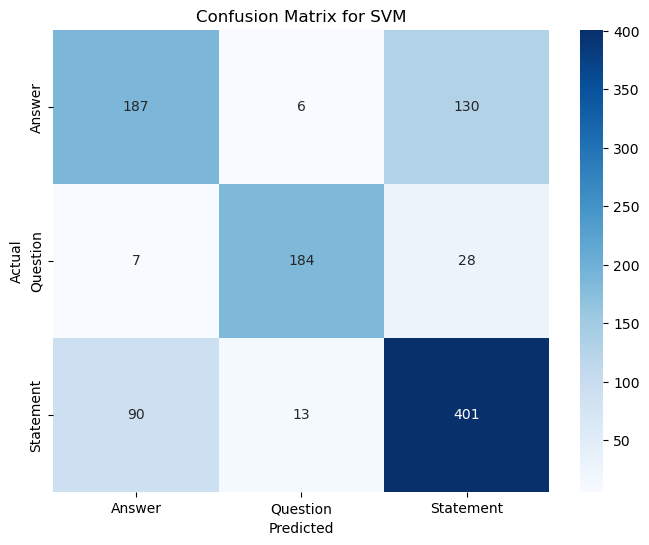

In [4]:
# Function to train and evaluate SVM
def run_svm(X_train, X_test, y_train, y_test, label_encoder):
    model = SVC()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print results
    print("Results for SVM:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    
    # Plot confusion matrix (assuming plot_confusion_matrix is defined elsewhere)
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "SVM")

# Call the updated function
run_svm(X_train, X_test, y_train, y_test, label_encoder)


Best Hyperparameters found by RandomizedSearchCV: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10.0}
Results for SVM after Randomized Hyperparameter Tuning:
Training Accuracy: 0.8073
Test Accuracy: 0.7342
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.64      0.57      0.60       323
    Question       0.90      0.83      0.86       219
   Statement       0.72      0.80      0.76       504

    accuracy                           0.73      1046
   macro avg       0.75      0.73      0.74      1046
weighted avg       0.73      0.73      0.73      1046

Confusion Matrix for Training Set:


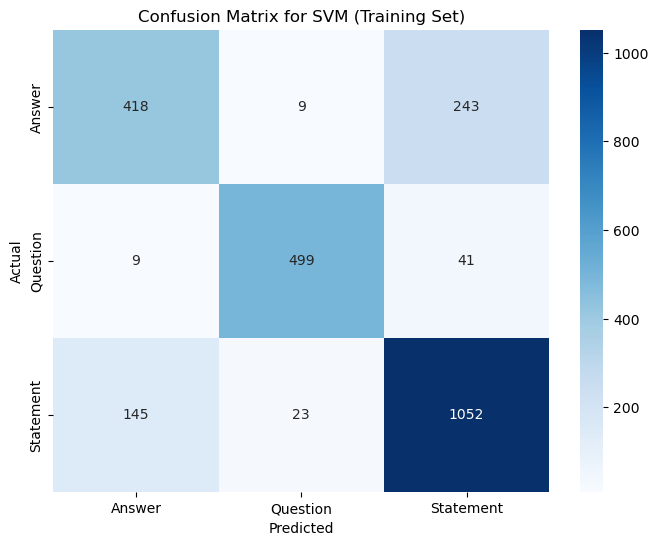

Confusion Matrix for Test Set:


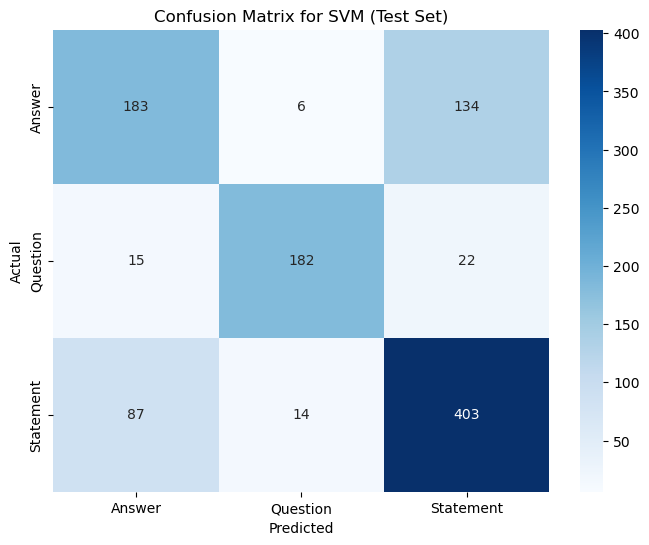

In [5]:
def run_svm_optimized(X_train, X_test, y_train, y_test, label_encoder):
    # Define a smaller hyperparameter distribution for RandomizedSearchCV
    param_dist = {
        'C': np.logspace(-2, 2, 5),        # Reduce range of C
        'gamma': ['scale', 'auto'],        # Remove specific gamma values for faster search
        'kernel': ['linear', 'rbf'],       # Focus on the two most common kernels
    }

    # Initialize SVM and RandomizedSearchCV for hyperparameter tuning
    model = SVC()
    random_search = RandomizedSearchCV(model, param_dist, n_iter=10, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
    
    # Train the model using RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    # Get the best model after tuning
    best_model = random_search.best_estimator_
    
    # Predictions on the test set
    y_pred_test = best_model.predict(X_test)
    test_accuracy = best_model.score(X_test, y_test)
    
    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = best_model.predict(X_train)
    train_accuracy = best_model.score(X_train, y_train)
    
    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print results
    print("Best Hyperparameters found by RandomizedSearchCV:", random_search.best_params_)
    print("Results for SVM after Randomized Hyperparameter Tuning:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep)
    
    # Plot confusion matrix for the training set
    print("Confusion Matrix for Training Set:")
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "SVM (Training Set)")
    
    # Plot confusion matrix for the test set
    print("Confusion Matrix for Test Set:")
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "SVM (Test Set)")

# Call the optimized function
run_svm_optimized(X_train, X_test, y_train, y_test, label_encoder)

Results for Decision Tree:
Training Accuracy: 0.9721
Test Accuracy: 0.6128
Classification Report:
              precision    recall  f1-score   support

      Answer       0.50      0.45      0.47       323
    Question       0.69      0.74      0.72       219
   Statement       0.64      0.66      0.65       504

    accuracy                           0.61      1046
   macro avg       0.61      0.62      0.61      1046
weighted avg       0.61      0.61      0.61      1046



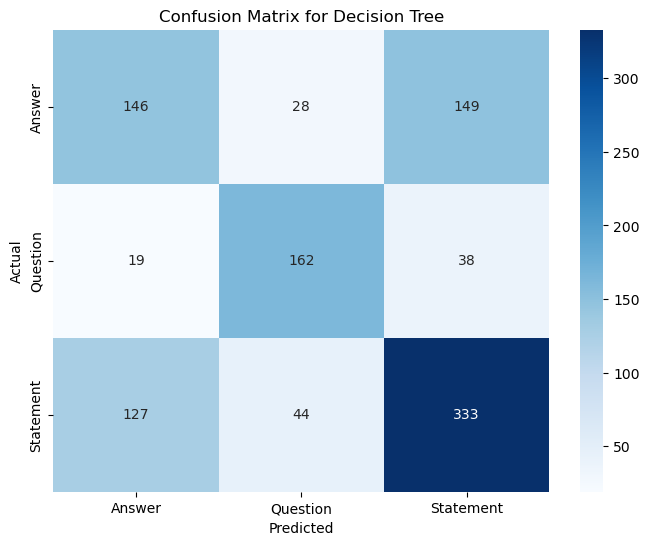

In [6]:
# Function to train and evaluate Decision Tree
def run_decision_tree(X_train, X_test, y_train, y_test, label_encoder):
    model = DecisionTreeClassifier()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print results
    print("Results for Decision Tree:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    
    # Plot confusion matrix (assuming plot_confusion_matrix is defined elsewhere)
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Decision Tree")

# Call the updated function
run_decision_tree(X_train, X_test, y_train, y_test, label_encoder)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}
Results for Decision Tree with RandomizedSearchCV:
Training Accuracy: 0.9356
Test Accuracy: 0.6176
Classification Report:
              precision    recall  f1-score   support

      Answer       0.53      0.49      0.51       323
    Question       0.69      0.66      0.67       219
   Statement       0.64      0.68      0.66       504

    accuracy                           0.62      1046
   macro avg       0.62      0.61      0.61      1046
weighted avg       0.62      0.62      0.62      1046



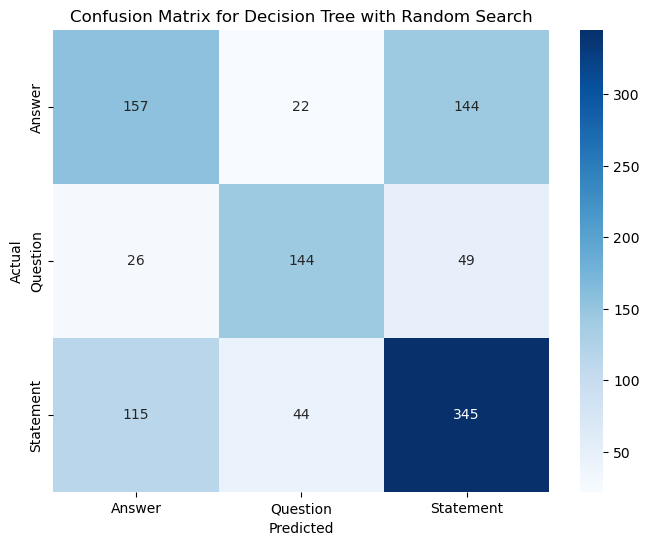

In [7]:
def run_decision_tree_with_random_search(X_train, X_test, y_train, y_test, label_encoder):
    # Decision Tree model
    model = DecisionTreeClassifier()

    # Hyperparameter space for RandomizedSearchCV
    param_dist = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    }

    # RandomizedSearchCV setup
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=50,  # number of iterations
        cv=5,       # cross-validation
        verbose=1,  # display progress
        n_jobs=-1,  # use all processors
        random_state=42
    )

    # Train the model with random search
    random_search.fit(X_train, y_train)

    # Best parameters and best estimator
    print(f"Best Parameters: {random_search.best_params_}")

    # Predictions on the test set
    y_pred_test = random_search.predict(X_test)
    test_accuracy = random_search.score(X_test, y_test)

    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = random_search.predict(X_train)
    train_accuracy = random_search.score(X_train, y_train)

    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print results
    print("Results for Decision Tree with RandomizedSearchCV:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    
    # Plot confusion matrix (assuming plot_confusion_matrix is defined elsewhere)
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Decision Tree with Random Search")

# Call the updated function
run_decision_tree_with_random_search(X_train, X_test, y_train, y_test, label_encoder)

Results for Random Forest:
Training Accuracy: 0.9721
Test Accuracy: 0.7161
Classification Report:
              precision    recall  f1-score   support

      Answer       0.63      0.49      0.55       323
    Question       0.92      0.80      0.86       219
   Statement       0.69      0.83      0.75       504

    accuracy                           0.72      1046
   macro avg       0.75      0.71      0.72      1046
weighted avg       0.72      0.72      0.71      1046



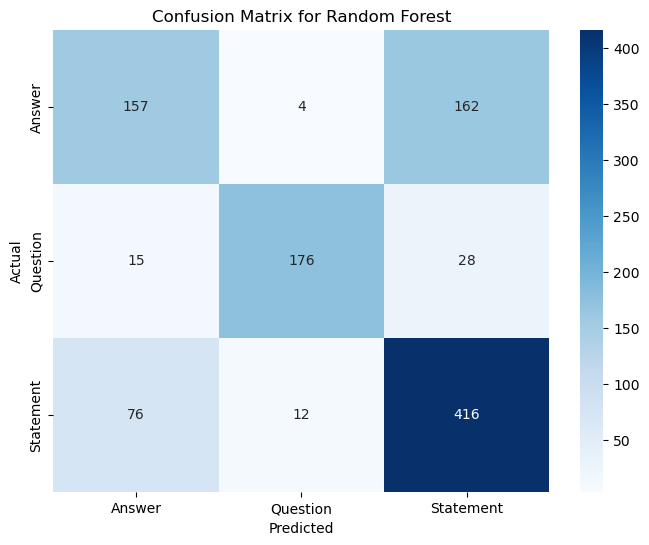

In [8]:
# Function to train and evaluate Random Forest
def run_random_forest(X_train, X_test, y_train, y_test, label_encoder):
    model = RandomForestClassifier()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print results
    print("Results for Random Forest:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    
    # Plot confusion matrix (assuming plot_confusion_matrix is defined elsewhere)
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Random Forest")

# Call the updated function
run_random_forest(X_train, X_test, y_train, y_test, label_encoder)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, label_encoder, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Function to run Random Forest with RandomizedSearchCV
def run_random_forest_with_random_search(X_train, X_test, y_train, y_test, label_encoder):
    # Random Forest model
    model = RandomForestClassifier()

    # Corrected hyperparameter space for RandomizedSearchCV
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
        'max_features': ['sqrt', 'log2', None],     # Number of features to consider at every split
        'max_depth': [None, 10, 20, 30, 40],        # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required at each leaf node
        'bootstrap': [True, False]                  # Whether bootstrap samples are used when building trees
    }

    # RandomizedSearchCV setup
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=20,  # number of iterations (reduced for faster performance)
        cv=5,       # cross-validation
        verbose=1,  # display progress
        n_jobs=-1,  # use all processors
        random_state=42
    )

    # Train the model with random search
    random_search.fit(X_train, y_train)

    # Best parameters and best estimator
    print(f"Best Parameters: {random_search.best_params_}")

    # Predictions on the test set
    y_pred_test = random_search.predict(X_test)
    test_accuracy = random_search.score(X_test, y_test)

    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = random_search.predict(X_train)
    train_accuracy = random_search.score(X_train, y_train)

    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print results
    print("Results for Random Forest with RandomizedSearchCV:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Random Forest with Random Search")

# Call the updated function
run_random_forest_with_random_search(X_train, X_test, y_train, y_test, label_encoder)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost (Training Set):
Training Accuracy: 0.6872
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.48      0.47      0.47       670
    Question       0.96      0.92      0.94       549
   Statement       0.68      0.70      0.69      1220

    accuracy                           0.69      2439
   macro avg       0.71      0.70      0.70      2439
weighted avg       0.69      0.69      0.69      2439


Results for AdaBoost (Test Set):
Test Accuracy: 0.6023
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.44      0.42      0.43       323
    Question       0.90      0.77      0.83       219
   Statement       0.59      0.64      0.62       504

    accuracy                           0.60      1046
   macro avg       0.64      0.61      0.63      1046
weighted avg       0.61      0.60      0.60      1046



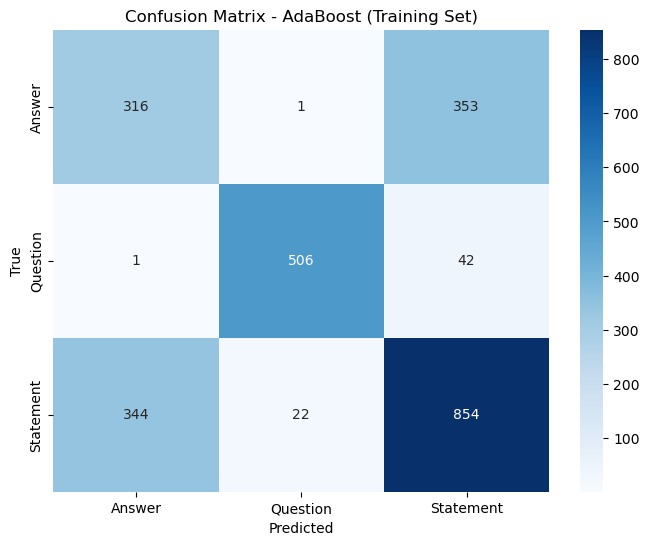

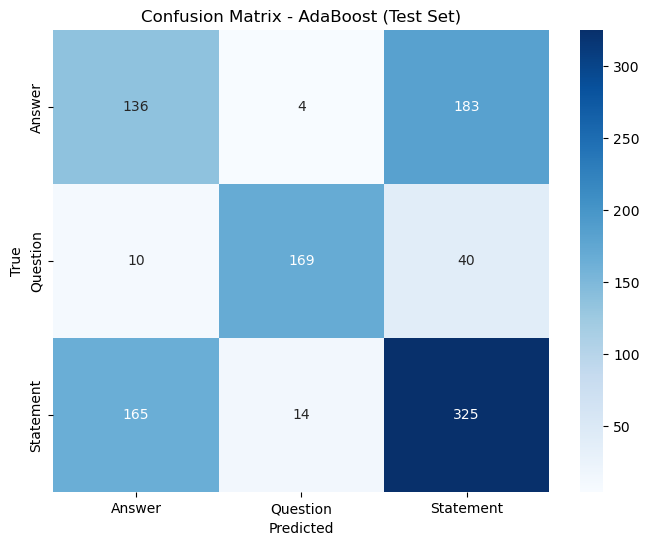

In [18]:
# Function to train and evaluate AdaBoost
def run_adaboost(X_train, X_test, y_train, y_test, label_encoder):
    model = AdaBoostClassifier()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print training results
    print("Results for AdaBoost (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for AdaBoost (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)
    
    # Plot confusion matrix for training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "AdaBoost (Training Set)")
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "AdaBoost (Test Set)")

# Call the updated function
run_adaboost(X_train, X_test, y_train, y_test, label_encoder)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
def run_naive_bayes(X_train, X_test, y_train, y_test, label_encoder):
    # Use MinMaxScaler to ensure that all values are non-negative
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Instantiate the Multinomial Naive Bayes model
    model = MultinomialNB()
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test_scaled)
    test_accuracy = model.score(X_test_scaled, y_test)
    
    # Predictions on the training set
    y_pred_train = model.predict(X_train_scaled)
    train_accuracy = model.score(X_train_scaled, y_train)
    
    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print training results
    print("Results for Naive Bayes (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for Naive Bayes (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)
    
    # Plot confusion matrix for training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "Naive Bayes (Training Set)")
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Naive Bayes (Test Set)")

# Call the updated function
run_naive_bayes(X_train, X_test, y_train, y_test, label_encoder)

In [ ]:
# Function to train and evaluate XGBoost
def run_xgboost(X_train, X_test, y_train, y_test, label_encoder):
    model = xgb.XGBClassifier(eval_metric='mlogloss')
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print training results
    print("Results for XGBoost (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for XGBoost (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)
    
    # Plot confusion matrix for the training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "XGBoost (Training Set)")
    
    # Plot confusion matrix for the test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "XGBoost (Test Set)")

# Call the updated function
run_xgboost(X_train, X_test, y_train, y_test, label_encoder)

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Function to train and evaluate KNN
def run_knn(X_train, X_test, y_train, y_test, label_encoder):
    # Convert to NumPy arrays if they are not already
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    if not isinstance(X_test, np.ndarray):
        X_test = np.array(X_test)

    # Optional: Scaling (you can uncomment if needed)
    # from sklearn.preprocessing import MinMaxScaler
    # scaler = MinMaxScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    model = KNeighborsClassifier()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print training results
    print("Results for KNN (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for KNN (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)
    
    # Plot confusion matrix for the training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "KNN (Training Set)")
    
    # Plot confusion matrix for the test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "KNN (Test Set)")

# Call the updated function
run_knn(X_train, X_test, y_train, y_test, label_encoder)


In [ ]:
def run_naive_bayes_with_random_search(X_train, X_test, y_train, y_test, label_encoder):
    # Ensure that features are non-negative using MaxAbsScaler for sparse input
    scaler = MaxAbsScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Check for negative values
    if (X_train_scaled < 0).any() or (X_test_scaled < 0).any():
        print("Warning: Negative values detected in scaled data. Please check your preprocessing steps.")
        return

    # Naive Bayes model
    model = MultinomialNB()

    # Hyperparameter space for RandomizedSearchCV
    param_dist = {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],  # Smoothing parameter
        'fit_prior': [True, False],          # Whether to learn class priors or not
    }

    # RandomizedSearchCV setup
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=10,   # number of iterations
        cv=5,        # cross-validation
        verbose=1,   # display progress
        n_jobs=-1,   # use all processors
        random_state=42
    )

    # Train the model with random search
    try:
        random_search.fit(X_train_scaled, y_train)
    except ValueError as e:
        print("Error during fitting:", e)
        return

    # Best parameters and best estimator
    print(f"Best Parameters: {random_search.best_params_}")

    # Predictions on the test set
    y_pred_test = random_search.predict(X_test_scaled)
    test_accuracy = random_search.score(X_test_scaled, y_test)

    # Predictions on the training set
    y_pred_train = random_search.predict(X_train_scaled)
    train_accuracy = random_search.score(X_train_scaled, y_train)

    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print training results
    print("Results for Naive Bayes with RandomizedSearchCV (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for Naive Bayes with RandomizedSearchCV (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)

    # Plot confusion matrix for training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "Naive Bayes (Training Set)")
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Naive Bayes (Test Set)")

# Call the updated function
run_naive_bayes_with_random_search(X_train, X_test, y_train, y_test, label_encoder)


In [ ]:
print("Original X_train contains negative values:", (X_train < 0).any())
print("Original X_test contains negative values:", (X_test < 0).any())
# Example transformation to ensure non-negative values
X_train = np.maximum(X_train, 0)  # Replace negative values with 0
X_test = np.maximum(X_test, 0)    # Replace negative values with 0


In [ ]:

def run_xgboost_with_random_search(X_train, X_test, y_train, y_test, label_encoder):
    # XGBoost model without use_label_encoder
    model = xgb.XGBClassifier(eval_metric='mlogloss')

    # Hyperparameter space for RandomizedSearchCV
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],    # Number of trees
        'learning_rate': [0.01, 0.05, 0.1, 0.2],     # Step size shrinkage
        'max_depth': [3, 4, 5, 6, 7],                # Maximum depth of a tree
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],     # Subsample ratio of the training instance
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree
        'gamma': [0, 0.1, 0.2, 0.3, 0.4],           # Minimum loss reduction required to make a further partition on a leaf node
        'reg_alpha': [0, 0.01, 0.1, 1.0],           # L1 regularization term on weights
        'reg_lambda': [0.01, 0.1, 1.0]              # L2 regularization term on weights
    }

    # RandomizedSearchCV setup
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=50,   # number of iterations
        cv=5,        # cross-validation
        verbose=1,   # display progress
        n_jobs=-1,   # use all processors
        random_state=42
    )

    # Train the model with random search
    random_search.fit(X_train, y_train)

    # Best parameters and best estimator
    print(f"Best Parameters: {random_search.best_params_}")

    # Predictions on the test set
    y_pred_test = random_search.predict(X_test)
    test_accuracy = random_search.score(X_test, y_test)

    # Predictions on the training set
    y_pred_train = random_search.predict(X_train)
    train_accuracy = random_search.score(X_train, y_train)

    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print training results
    print("Results for XGBoost with RandomizedSearchCV (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for XGBoost with RandomizedSearchCV (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)

    # Plot confusion matrix for training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "XGBoost (Training Set)")
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "XGBoost (Test Set)")

# Call the updated function
run_xgboost_with_random_search(X_train, X_test, y_train, y_test, label_encoder)